# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
#list(df_new['Target'])

In [11]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [12]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [13]:
# create empty dictionary
target_dfs = {}

In [14]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [15]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [16]:
# find row with maximum amount of data points for each target
max_dfrows = {}

In [17]:
for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [18]:
#max_dfrows

In [19]:
frames = list(max_dfrows[target] for target in targets)

In [20]:
merged_df = pd.concat(frames, axis=0)

In [21]:
units = list(set(merged_df['Unit']))

In [22]:
units.remove('Percent')
units

['Constant USD', 'USD', 'Metric Tons']

In [23]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9


In [24]:
merged_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
155,50,Environment (percent),Coverage of protected areas in relation to mar...,14,14.5,14.5.1,Percent,Units,NaN,NaN,...,NaN,7.44,NaN,NaN,NaN,NaN,11.92,12.74,NaN,5
117,13,E&P (Percent),Remittance costs as a proportion of the amount...,10,10.c,10.c.1,Percent,Units,NaN,NaN,...,NaN,NaN,8.9,9,8.6,8.2,7.5,NaN,NaN,5
65,123,Population,Death rate due to road traffic injuries,3,3.6,3.6.1,Percent,Units,NaN,NaN,...,NaN,1.8,NaN,NaN,1.74,NaN,NaN,NaN,NaN,4
44,173,Population,Unsentenced detainees as a proportion of overa...,16,16.3,16.3.2,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,31,NaN,NaN,2
70,128,Population,Mortality rate attributed to unintentional poi...,3,3.9,3.9.3,Percent,Units,NaN,NaN,...,NaN,0.16,NaN,NaN,NaN,NaN,0.147,NaN,NaN,4


### clean-up data frames

In [25]:
# Drop unused columns, transpose
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [26]:
final_t

Target,14.5,10.c,3.6,16.3,3.9,1.1,7.1,8.4,17.2,15.2,...,16.a,15.1,4.2,17.8,17.3,2.1,6.1,9.5,8.2,7.2
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.6,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.5,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.2,NaN,NaN,NaN,NaN


In [27]:
# shuffle data
final_t_shuffled = final_t.sample(frac=1).reset_index(drop=True)
final_t_shuffled

Target,14.5,10.c,3.6,16.3,3.9,1.1,7.1,8.4,17.2,15.2,...,16.a,15.1,4.2,17.8,17.3,2.1,6.1,9.5,8.2,7.2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.6,NaN,NaN,NaN,NaN
2,11.92,7.5,NaN,31,0.147,NaN,NaN,NaN,0.000131555,NaN,...,35.5,43.23,NaN,43.75,0.76,10.8,54.81,NaN,1.67,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,43.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.78,0.000112242,NaN,...,NaN,41.28,58.89,23.18,0.65,13,52.49,98.358,1.83,17.14
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.1,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7.44,NaN,1.8,NaN,0.16,NaN,70.2,10.1,0.00012063,7.09,...,32.9,41.93,60.44,29.11,0.65,12.1,55.55,101.895,4.07,17.51
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.42,0.000109094,NaN,...,NaN,39.42,58.66,17.46,0.58,14.3,49.46,92.935,3.85,16.97
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.8,0.00010033,NaN,...,NaN,40.73,59.07,20.54,0.62,13.7,50.98,95.845,3.79,16.91


### R-squared value of linear regression to detect connections

In [28]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

mask_train = ~np.isnan(targets_X_train) & ~np.isnan(targets_Y_train)
print(mask_train)
targets_X_train = final_t_shuffled[targetx][:-6].reshape(-1, 1)
print(targets_X_train)
print(targets_X_train[mask_train])

In [29]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


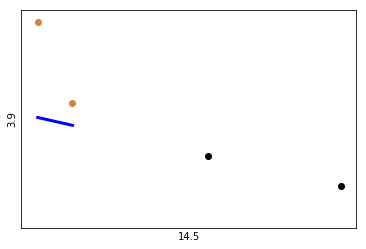

14.5 3.9
MAE: 0.02560
RMSE: 0.03008
R2: 0.000
--------------------------




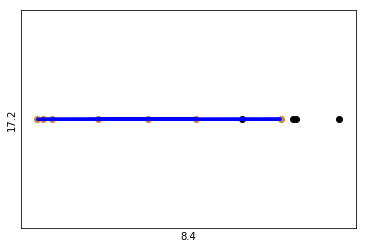

8.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.667
--------------------------


8.4 3.3
MAE: 1.07131
RMSE: 1.21155
R2: 0.000
--------------------------




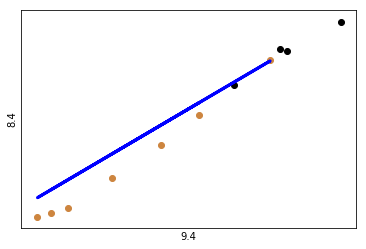

9.4 8.4
MAE: 0.19622
RMSE: 0.21578
R2: 0.865
--------------------------




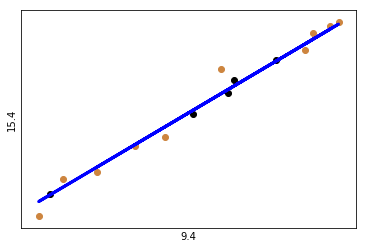

9.4 15.4
MAE: 0.42952
RMSE: 0.55305
R2: 0.977
--------------------------




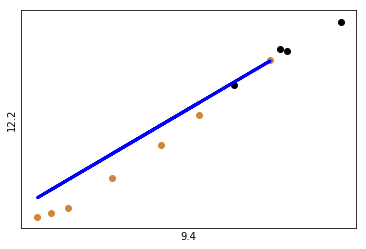

9.4 12.2
MAE: 0.19622
RMSE: 0.21578
R2: 0.865
--------------------------


9.4 8.1
MAE: 1.60112
RMSE: 2.10257
R2: 0.000
--------------------------




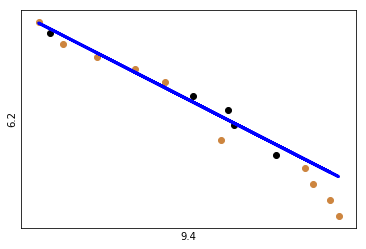

9.4 6.2
MAE: 0.66243
RMSE: 0.87006
R2: 0.924
--------------------------


9.4 9.c
MAE: 6.24236
RMSE: 8.89290
R2: 0.682
--------------------------




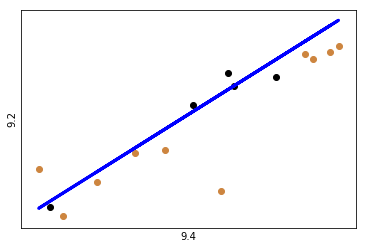

9.4 9.2
MAE: 0.20418
RMSE: 0.26953
R2: 0.650
--------------------------


9.4 14.4
MAE: 6.26855
RMSE: 6.46225
R2: 0.000
--------------------------


17.19 9.4
MAE: 1314755419.75639
RMSE: 1601982644.00476
R2: 0.000
--------------------------


17.19 15.1
MAE: 1.37325
RMSE: 1.60100
R2: 0.000
--------------------------


17.19 4.2
MAE: 3.15334
RMSE: 3.92769
R2: 0.000
--------------------------


17.19 17.8
MAE: 7.87008
RMSE: 8.92002
R2: 0.000
--------------------------




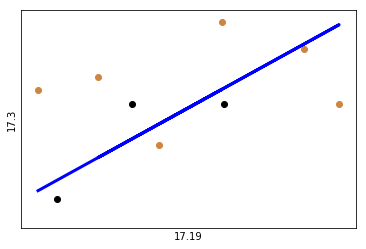

17.19 17.3
MAE: 0.04334
RMSE: 0.05009
R2: 0.000
--------------------------


17.19 2.1
MAE: 1.26933
RMSE: 1.43700
R2: 0.000
--------------------------


17.19 6.1
MAE: 3.33041
RMSE: 3.67645
R2: 0.000
--------------------------


17.19 9.5
MAE: 5.99630
RMSE: 6.80376
R2: 0.000
--------------------------


17.19 8.2
MAE: 1.63939
RMSE: 1.93178
R2: 0.000
--------------------------




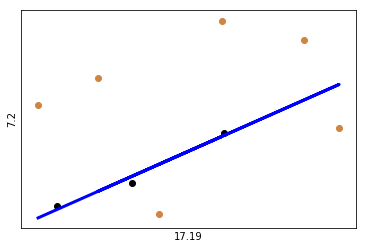

17.19 7.2
MAE: 0.60723
RMSE: 0.65031
R2: 0.000
--------------------------


8.4 15.4
MAE: 1.11303
RMSE: 1.25897
R2: 0.708
--------------------------




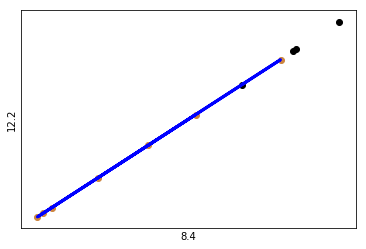

8.4 12.2
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
--------------------------


8.4 8.1
MAE: 1.49909
RMSE: 2.20350
R2: 0.000
--------------------------


8.4 6.2
MAE: 1.98155
RMSE: 2.12129
R2: 0.000
--------------------------


8.4 9.c
MAE: 9.30700
RMSE: 10.03396
R2: 0.203
--------------------------




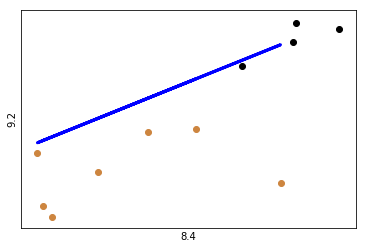

8.4 9.2
MAE: 0.32677
RMSE: 0.38259
R2: 0.000
--------------------------


8.4 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
--------------------------




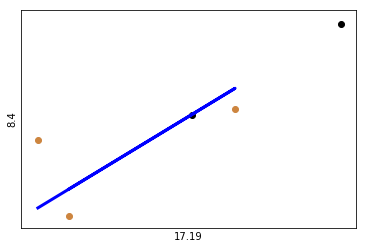

17.19 8.4
MAE: 0.13689
RMSE: 0.15539
R2: 0.053
--------------------------




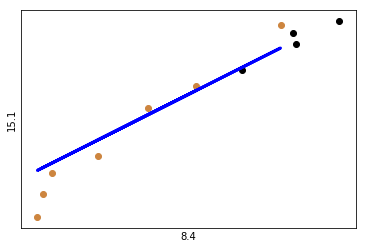

8.4 15.1
MAE: 0.97395
RMSE: 1.19860
R2: 0.859
--------------------------




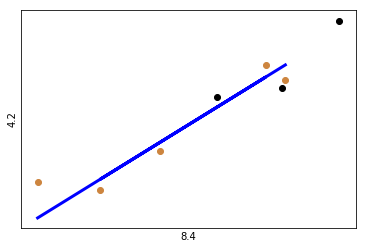

8.4 4.2
MAE: 0.37950
RMSE: 0.44402
R2: 0.864
--------------------------


8.4 17.8
MAE: 10.65011
RMSE: 11.54664
R2: 0.000
--------------------------




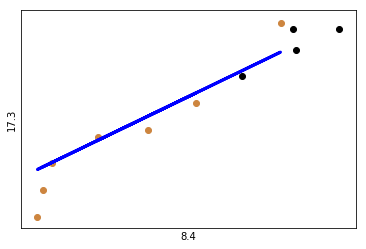

8.4 17.3
MAE: 0.02745
RMSE: 0.03556
R2: 0.836
--------------------------


8.4 2.1
MAE: 2.43654
RMSE: 2.75036
R2: 0.000
--------------------------


8.4 6.1
MAE: 3.54724
RMSE: 3.74852
R2: 0.215
--------------------------


8.4 9.5
MAE: 5.50800
RMSE: 5.88486
R2: 0.123
--------------------------


8.4 8.2
MAE: 1.35597
RMSE: 1.86942
R2: 0.000
--------------------------


8.4 7.2
MAE: 1.00194
RMSE: 1.11562
R2: 0.000
--------------------------


17.2 14.5
MAE: 7.02134
RMSE: 8.89791
R2: 0.000
--------------------------




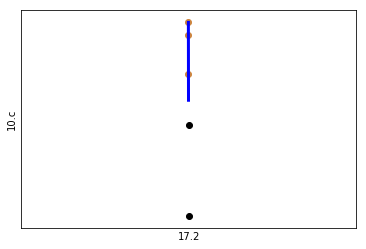

17.2 10.c
MAE: 0.17283
RMSE: 0.21351
R2: 0.000
--------------------------




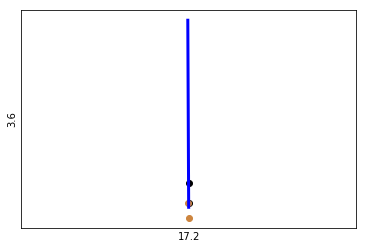

17.2 3.6
MAE: 0.39440
RMSE: 0.52898
R2: 0.000
--------------------------




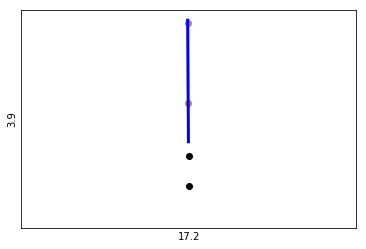

17.2 3.9
MAE: 0.00894
RMSE: 0.01181
R2: 0.545
--------------------------


17.2 7.1
MAE: 18.02299
RMSE: 25.16733
R2: 0.000
--------------------------


17.2 3.1
MAE: 3.45251
RMSE: 3.52608
R2: 0.000
--------------------------




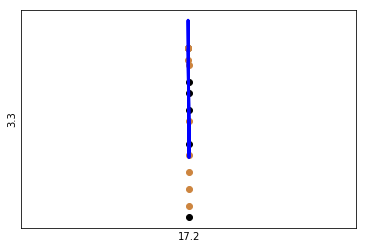

17.2 3.3
MAE: 0.45170
RMSE: 0.59028
R2: 0.705
--------------------------




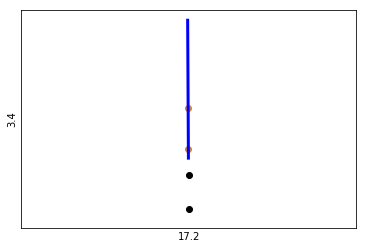

17.2 3.4
MAE: 0.07121
RMSE: 0.09159
R2: 0.000
--------------------------




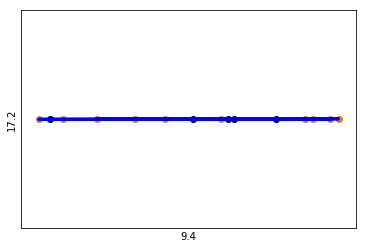

9.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.825
--------------------------


9.4 15.1
MAE: 1.08250
RMSE: 1.23071
R2: 0.904
--------------------------


9.4 4.2
MAE: 2.01441
RMSE: 2.67969
R2: 0.516
--------------------------


9.4 17.8
MAE: 3.16273
RMSE: 4.05920
R2: 0.882
--------------------------




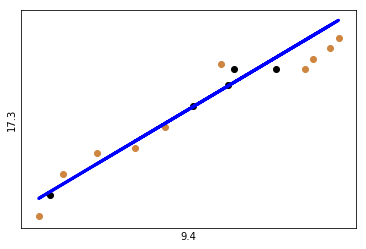

9.4 17.3
MAE: 0.03218
RMSE: 0.03588
R2: 0.897
--------------------------




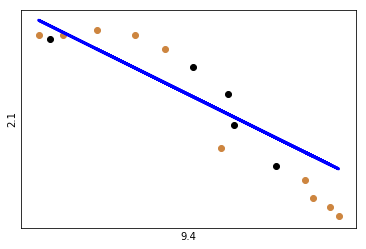

9.4 2.1
MAE: 0.66173
RMSE: 0.72425
R2: 0.826
--------------------------


9.4 6.1
MAE: 1.35607
RMSE: 1.78206
R2: 0.902
--------------------------


9.4 9.5
MAE: 1.88205
RMSE: 2.33306
R2: 0.953
--------------------------


9.4 8.2
MAE: 1.72987
RMSE: 2.09379
R2: 0.000
--------------------------




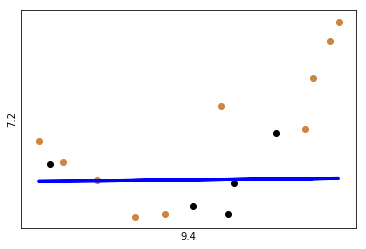

9.4 7.2
MAE: 0.47919
RMSE: 0.60031
R2: 0.000
--------------------------


3.1 14.5
MAE: 5.09433
RMSE: 6.10941
R2: 0.000
--------------------------




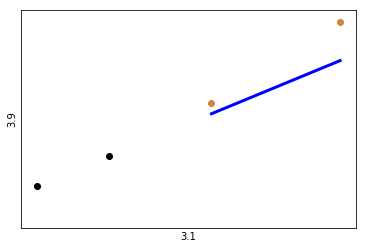

3.1 3.9
MAE: 0.01082
RMSE: 0.01238
R2: 0.500
--------------------------


3.1 3.3
MAE: 1.41833
RMSE: 1.73446
R2: 0.000
--------------------------




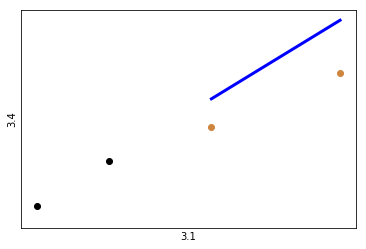

3.1 3.4
MAE: 0.04567
RMSE: 0.04767
R2: 0.000
--------------------------




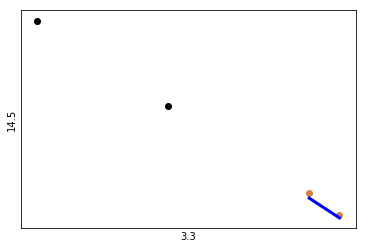

3.3 14.5
MAE: 0.20654
RMSE: 0.21747
R2: 0.862
--------------------------


3.3 10.c
MAE: 1.46667
RMSE: 1.64469
R2: 0.000
--------------------------




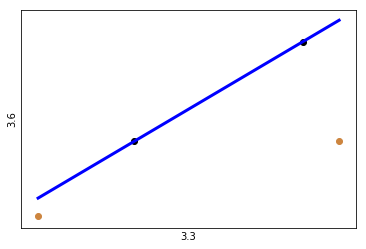

3.3 3.6
MAE: 0.05571
RMSE: 0.06943
R2: 0.000
--------------------------




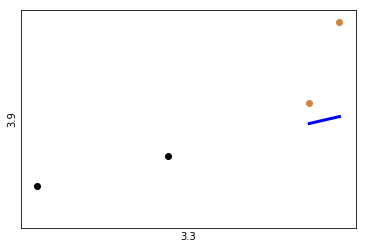

3.3 3.9
MAE: 0.02500
RMSE: 0.02968
R2: 0.000
--------------------------


3.3 7.1
MAE: 1.57818
RMSE: 1.91389
R2: 0.000
--------------------------




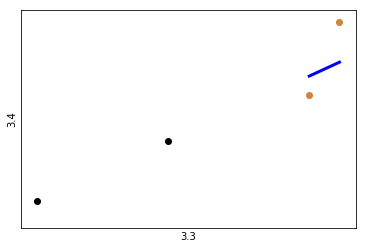

3.3 3.4
MAE: 0.02473
RMSE: 0.02628
R2: 0.258
--------------------------




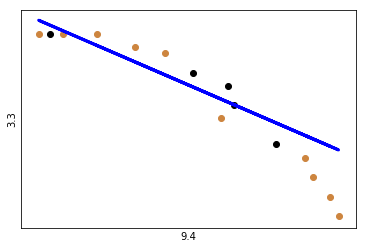

9.4 3.3
MAE: 0.40045
RMSE: 0.49123
R2: 0.796
--------------------------


3.4 14.5
MAE: 2.14780
RMSE: 2.37029
R2: 0.000
--------------------------




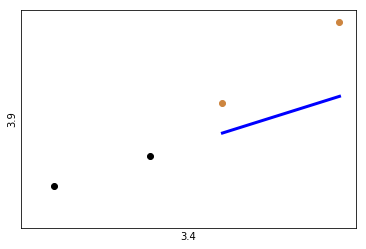

3.4 3.9
MAE: 0.02269
RMSE: 0.02463
R2: 0.000
--------------------------




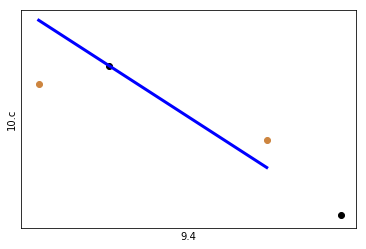

9.4 10.c
MAE: 0.24333
RMSE: 0.26261
R2: 0.000
--------------------------




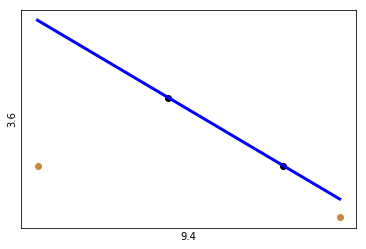

9.4 3.6
MAE: 0.09595
RMSE: 0.12198
R2: 0.000
--------------------------


9.4 7.1
MAE: 2.30338
RMSE: 2.69208
R2: 0.000
--------------------------


15.4 14.5
MAE: 5.81000
RMSE: 7.54574
R2: 0.000
--------------------------


15.4 10.c
MAE: 12.14167
RMSE: 15.21297
R2: 0.000
--------------------------




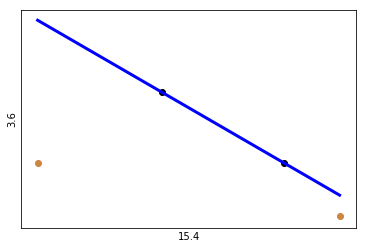

15.4 3.6
MAE: 0.09260
RMSE: 0.11523
R2: 0.000
--------------------------




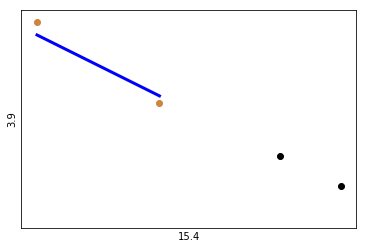

15.4 3.9
MAE: 0.00434
RMSE: 0.00456
R2: 0.932
--------------------------


15.4 7.1
MAE: 3.13170
RMSE: 3.45628
R2: 0.000
--------------------------


17.2 15.4
MAE: 1.54446
RMSE: 1.74491
R2: 0.780
--------------------------


17.2 12.2
MAE: 0.82114
RMSE: 0.88507
R2: 0.000
--------------------------


17.2 8.1
MAE: 1.22555
RMSE: 1.84557
R2: 0.000
--------------------------


17.2 6.2
MAE: 1.04012
RMSE: 1.37841
R2: 0.808
--------------------------


17.2 9.c
MAE: 8.54287
RMSE: 10.90216
R2: 0.522
--------------------------




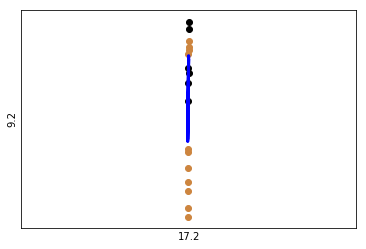

17.2 9.2
MAE: 0.33745
RMSE: 0.41588
R2: 0.200
--------------------------


17.2 14.4
MAE: 6.58916
RMSE: 6.76733
R2: 0.000
--------------------------




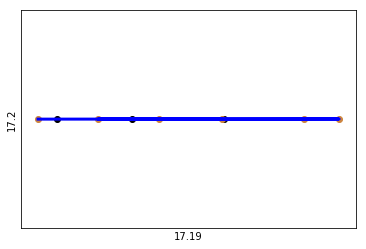

17.19 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.000
--------------------------


12.2 3.3
MAE: 1.07131
RMSE: 1.21155
R2: 0.000
--------------------------


12.2 15.4
MAE: 1.11303
RMSE: 1.25897
R2: 0.708
--------------------------


12.2 8.1
MAE: 1.49909
RMSE: 2.20350
R2: 0.000
--------------------------


12.2 6.2
MAE: 1.98155
RMSE: 2.12129
R2: 0.000
--------------------------


12.2 9.c
MAE: 9.30700
RMSE: 10.03396
R2: 0.203
--------------------------




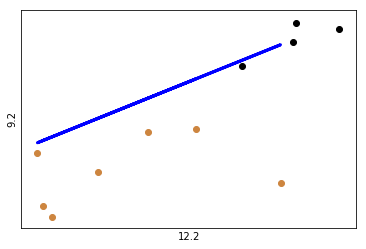

12.2 9.2
MAE: 0.32677
RMSE: 0.38259
R2: 0.000
--------------------------


12.2 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
--------------------------




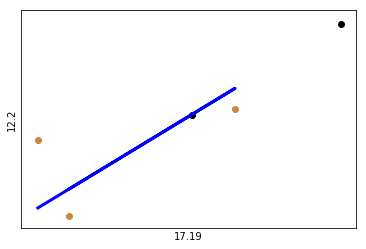

17.19 12.2
MAE: 0.13689
RMSE: 0.15539
R2: 0.053
--------------------------


8.1 14.5
MAE: 5.59281
RMSE: 5.61460
R2: 0.000
--------------------------


8.1 10.c
MAE: 1.88667
RMSE: 1.95146
R2: 0.000
--------------------------




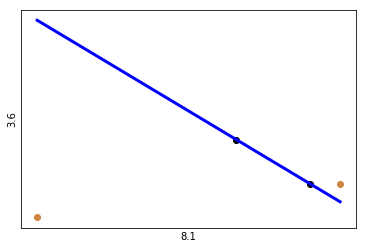

8.1 3.6
MAE: 0.19426
RMSE: 0.25289
R2: 0.000
--------------------------




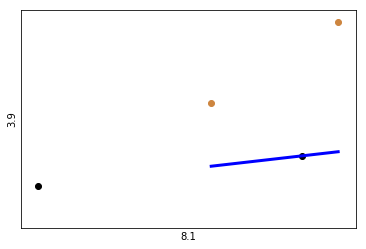

8.1 3.9
MAE: 0.04183
RMSE: 0.04423
R2: 0.000
--------------------------


8.1 7.1
MAE: 5.85048
RMSE: 5.90940
R2: 0.000
--------------------------


8.1 3.1
MAE: 7.15657
RMSE: 7.41156
R2: 0.000
--------------------------


8.1 3.3
MAE: 1.09330
RMSE: 1.13435
R2: 0.000
--------------------------




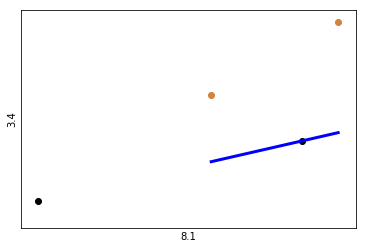

8.1 3.4
MAE: 0.07361
RMSE: 0.07589
R2: 0.000
--------------------------


8.1 15.4
MAE: 4.02346
RMSE: 4.21497
R2: 0.000
--------------------------


8.1 6.2
MAE: 3.33074
RMSE: 3.45771
R2: 0.000
--------------------------


8.1 9.c
MAE: 18.00261
RMSE: 18.78685
R2: 0.000
--------------------------




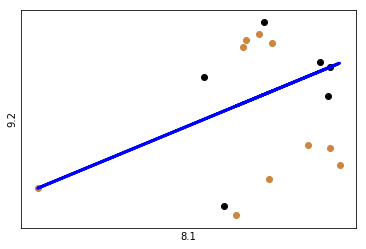

8.1 9.2
MAE: 0.45539
RMSE: 0.49626
R2: 0.000
--------------------------


8.1 14.4
MAE: 5.74301
RMSE: 6.05120
R2: 0.000
--------------------------


17.19 8.1
MAE: 1.48234
RMSE: 2.17992
R2: 0.000
--------------------------


6.2 14.5
MAE: 1.14619
RMSE: 1.39959
R2: 0.000
--------------------------




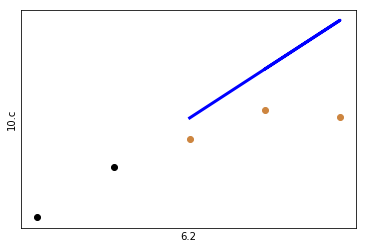

6.2 10.c
MAE: 0.74518
RMSE: 0.87197
R2: 0.000
--------------------------




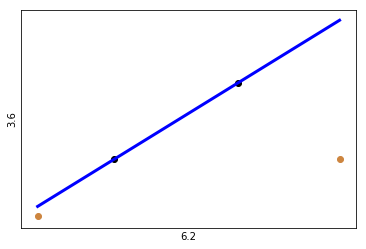

6.2 3.6
MAE: 0.07814
RMSE: 0.10339
R2: 0.000
--------------------------




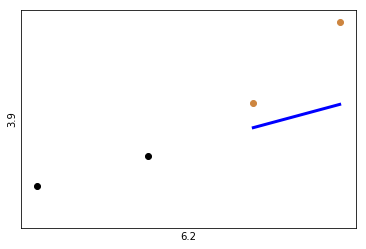

6.2 3.9
MAE: 0.02327
RMSE: 0.02640
R2: 0.000
--------------------------




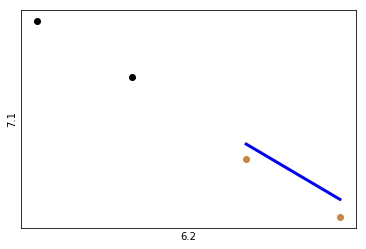

6.2 7.1
MAE: 0.81179
RMSE: 0.81571
R2: 0.692
--------------------------


6.2 3.1
MAE: 2.87355
RMSE: 3.23721
R2: 0.000
--------------------------




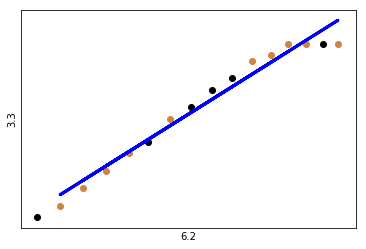

6.2 3.3
MAE: 0.15163
RMSE: 0.18146
R2: 0.972
--------------------------




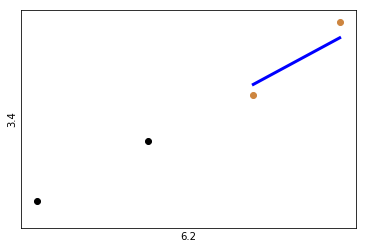

6.2 3.4
MAE: 0.01118
RMSE: 0.01140
R2: 0.860
--------------------------




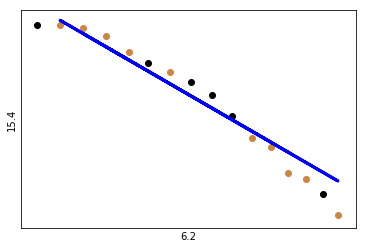

6.2 15.4
MAE: 0.66801
RMSE: 0.81899
R2: 0.949
--------------------------


6.2 9.c
MAE: 6.60676
RMSE: 8.23588
R2: 0.727
--------------------------




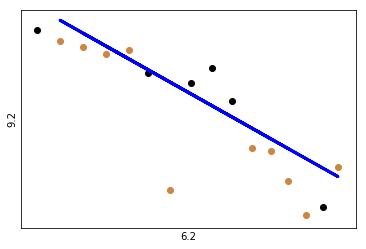

6.2 9.2
MAE: 0.20367
RMSE: 0.29135
R2: 0.591
--------------------------


6.2 14.4
MAE: 6.05674
RMSE: 6.25550
R2: 0.000
--------------------------


17.19 6.2
MAE: 1.94326
RMSE: 2.17233
R2: 0.000
--------------------------


9.c 14.5
MAE: 4.86685
RMSE: 6.59337
R2: 0.000
--------------------------


9.c 10.c
MAE: 9.28039
RMSE: 10.81269
R2: 0.000
--------------------------




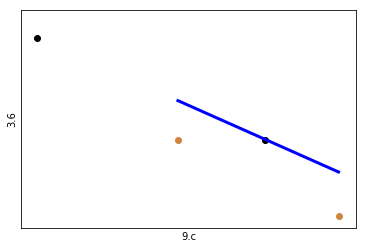

9.c 3.6
MAE: 0.03254
RMSE: 0.03259
R2: 0.000
--------------------------




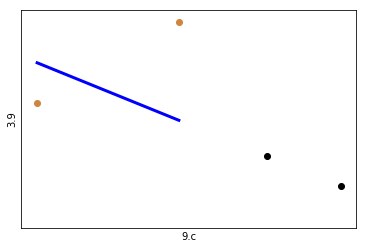

9.c 3.9
MAE: 0.02993
RMSE: 0.03251
R2: 0.000
--------------------------


9.c 7.1
MAE: 4.12649
RMSE: 4.14264
R2: 0.000
--------------------------


9.c 3.1
MAE: 5.51731
RMSE: 5.53425
R2: 0.000
--------------------------




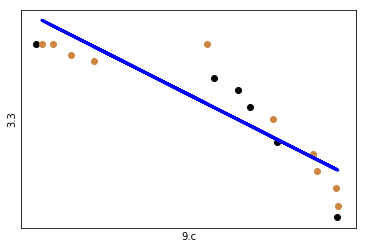

9.c 3.3
MAE: 0.38973
RMSE: 0.46537
R2: 0.817
--------------------------




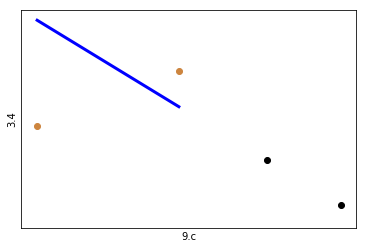

9.c 3.4
MAE: 0.07829
RMSE: 0.08722
R2: 0.000
--------------------------


9.c 15.4
MAE: 1.29632
RMSE: 2.07993
R2: 0.674
--------------------------




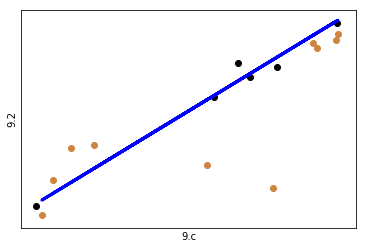

9.c 9.2
MAE: 0.22664
RMSE: 0.32931
R2: 0.477
--------------------------


9.c 14.4
MAE: 6.41877
RMSE: 6.62417
R2: 0.000
--------------------------


17.19 9.c
MAE: 5.73290
RMSE: 6.77359
R2: 0.000
--------------------------


9.2 14.5
MAE: 2.52467
RMSE: 3.07857
R2: 0.612
--------------------------




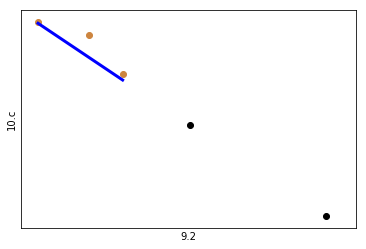

9.2 10.c
MAE: 0.07917
RMSE: 0.10533
R2: 0.616
--------------------------




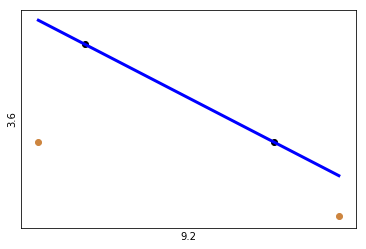

9.2 3.6
MAE: 0.06623
RMSE: 0.07417
R2: 0.000
--------------------------




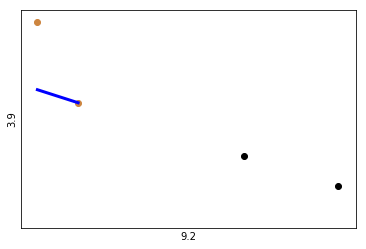

9.2 3.9
MAE: 0.01472
RMSE: 0.02079
R2: 0.000
--------------------------


9.2 7.1
MAE: 2.10091
RMSE: 2.19360
R2: 0.000
--------------------------


9.2 3.1
MAE: 2.00000
RMSE: 2.19317
R2: 0.315
--------------------------




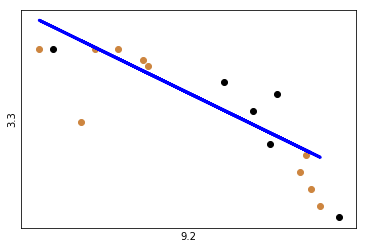

9.2 3.3
MAE: 0.45255
RMSE: 0.61762
R2: 0.677
--------------------------




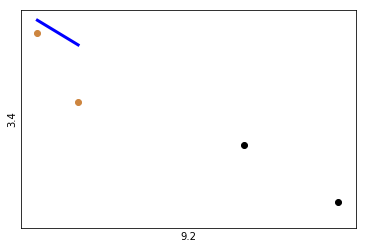

9.2 3.4
MAE: 0.03067
RMSE: 0.03643
R2: 0.000
--------------------------


9.2 15.4
MAE: 2.00896
RMSE: 2.79448
R2: 0.436
--------------------------


9.2 14.4
MAE: 6.34123
RMSE: 6.55857
R2: 0.000
--------------------------




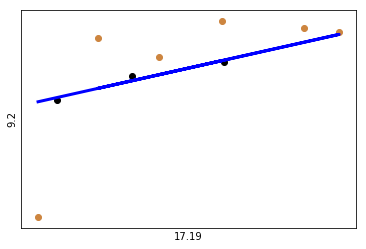

17.19 9.2
MAE: 0.21150
RMSE: 0.28996
R2: 0.365
--------------------------




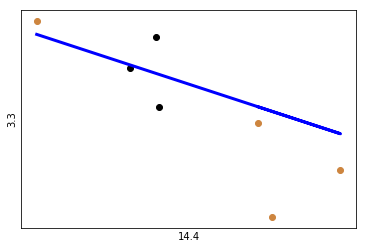

14.4 3.3
MAE: 0.54550
RMSE: 0.72457
R2: 0.387
--------------------------


14.4 15.4
MAE: 2.38303
RMSE: 2.72241
R2: 0.516
--------------------------


17.19 14.4
MAE: 4.45791
RMSE: 4.75958
R2: 0.000
--------------------------


17.19 10.c
MAE: 1.19140
RMSE: 1.22012
R2: 0.000
--------------------------




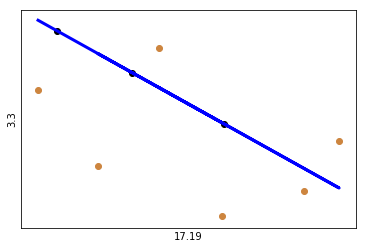

17.19 3.3
MAE: 0.76225
RMSE: 0.84677
R2: 0.000
--------------------------


17.19 15.4
MAE: 1.74139
RMSE: 2.01892
R2: 0.000
--------------------------


16.a 14.5
MAE: 9.34128
RMSE: 13.52644
R2: 0.000
--------------------------




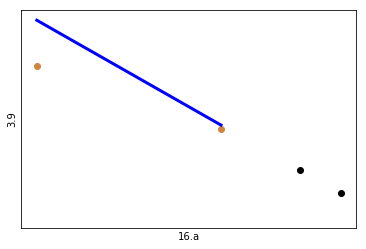

16.a 3.9
MAE: 0.01375
RMSE: 0.01809
R2: 0.000
--------------------------


17.2 16.a
MAE: 3.46218
RMSE: 3.68441
R2: 0.804
--------------------------


17.2 15.1
MAE: 2.50172
RMSE: 3.05238
R2: 0.458
--------------------------


17.2 4.2
MAE: 2.95251
RMSE: 3.67677
R2: 0.089
--------------------------


17.2 17.8
MAE: 4.62776
RMSE: 5.69487
R2: 0.767
--------------------------




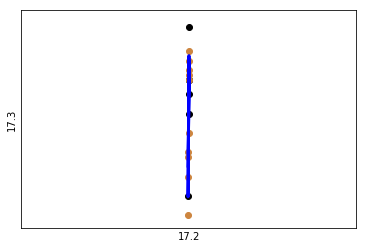

17.2 17.3
MAE: 0.02372
RMSE: 0.03976
R2: 0.874
--------------------------




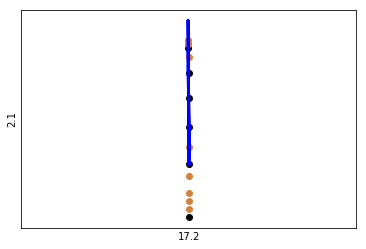

17.2 2.1
MAE: 0.75934
RMSE: 0.94718
R2: 0.702
--------------------------


17.2 6.1
MAE: 1.51960
RMSE: 2.04812
R2: 0.871
--------------------------


17.2 9.5
MAE: 4.04711
RMSE: 5.10489
R2: 0.774
--------------------------


17.2 8.2
MAE: 1.84550
RMSE: 2.30359
R2: 0.000
--------------------------




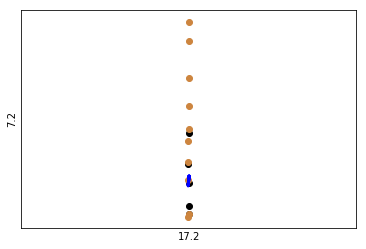

17.2 7.2
MAE: 0.48003
RMSE: 0.59288
R2: 0.000
--------------------------


15.1 14.5
MAE: 12.21985
RMSE: 17.14280
R2: 0.000
--------------------------


15.1 10.c
MAE: 9.16667
RMSE: 10.89593
R2: 0.000
--------------------------




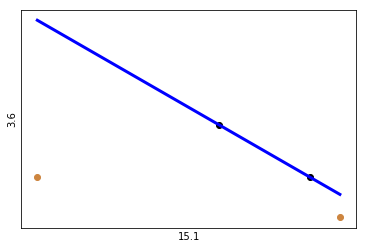

15.1 3.6
MAE: 0.13687
RMSE: 0.17109
R2: 0.000
--------------------------




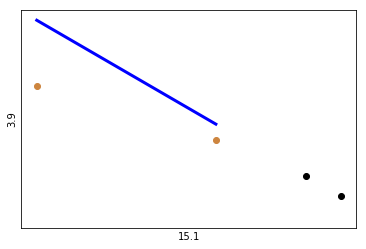

15.1 3.9
MAE: 0.02640
RMSE: 0.03082
R2: 0.000
--------------------------


15.1 7.1
MAE: 9.49905
RMSE: 11.26651
R2: 0.000
--------------------------


15.1 3.1
MAE: 8.58846
RMSE: 9.96704
R2: 0.000
--------------------------




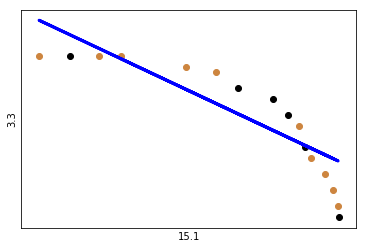

15.1 3.3
MAE: 0.41499
RMSE: 0.48006
R2: 0.805
--------------------------




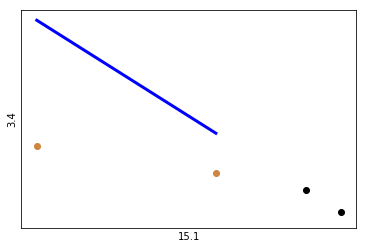

15.1 3.4
MAE: 0.18881
RMSE: 0.21271
R2: 0.000
--------------------------


15.1 15.4
MAE: 1.67254
RMSE: 2.55209
R2: 0.551
--------------------------




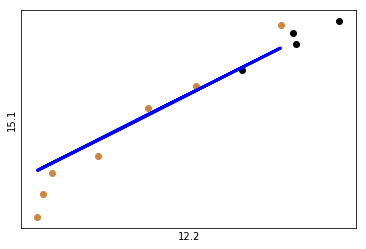

12.2 15.1
MAE: 0.97395
RMSE: 1.19860
R2: 0.859
--------------------------




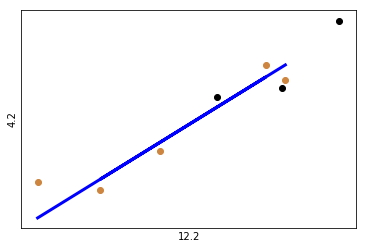

12.2 4.2
MAE: 0.37950
RMSE: 0.44402
R2: 0.864
--------------------------


12.2 17.8
MAE: 10.65011
RMSE: 11.54664
R2: 0.000
--------------------------




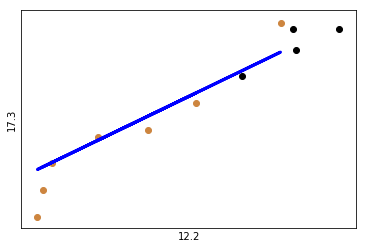

12.2 17.3
MAE: 0.02745
RMSE: 0.03556
R2: 0.836
--------------------------


12.2 2.1
MAE: 2.43654
RMSE: 2.75036
R2: 0.000
--------------------------


12.2 6.1
MAE: 3.54724
RMSE: 3.74852
R2: 0.215
--------------------------


12.2 9.5
MAE: 5.50800
RMSE: 5.88486
R2: 0.123
--------------------------


12.2 8.2
MAE: 1.35597
RMSE: 1.86942
R2: 0.000
--------------------------


12.2 7.2
MAE: 1.00194
RMSE: 1.11562
R2: 0.000
--------------------------




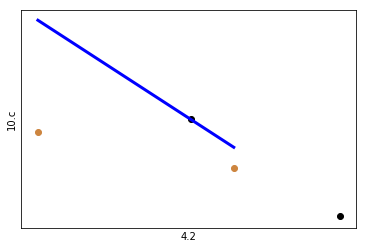

4.2 10.c
MAE: 0.54538
RMSE: 0.66194
R2: 0.000
--------------------------


4.2 3.3
MAE: 1.05986
RMSE: 1.31146
R2: 0.000
--------------------------


4.2 15.4
MAE: 2.41035
RMSE: 3.11988
R2: 0.000
--------------------------


4.2 8.1
MAE: 3.14276
RMSE: 3.52044
R2: 0.000
--------------------------


4.2 6.2
MAE: 2.43253
RMSE: 3.06668
R2: 0.000
--------------------------


4.2 9.c
MAE: 10.69428
RMSE: 11.57328
R2: 0.457
--------------------------




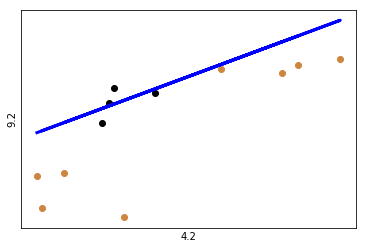

4.2 9.2
MAE: 0.32377
RMSE: 0.38684
R2: 0.186
--------------------------


4.2 14.4
MAE: 14.80011
RMSE: 18.12337
R2: 0.000
--------------------------


4.2 15.1
MAE: 2.48272
RMSE: 3.01644
R2: 0.000
--------------------------


4.2 17.8
MAE: 11.11869
RMSE: 13.49819
R2: 0.000
--------------------------




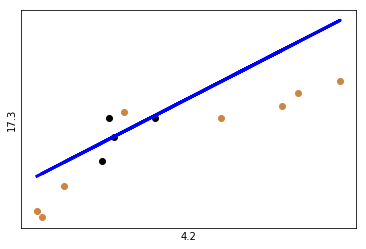

4.2 17.3
MAE: 0.06597
RMSE: 0.06967
R2: 0.299
--------------------------


4.2 2.1
MAE: 2.24658
RMSE: 2.82341
R2: 0.000
--------------------------


4.2 6.1
MAE: 7.09685
RMSE: 9.78110
R2: 0.000
--------------------------


4.2 9.5
MAE: 6.92767
RMSE: 9.30553
R2: 0.000
--------------------------


4.2 8.2
MAE: 2.88587
RMSE: 3.47712
R2: 0.000
--------------------------




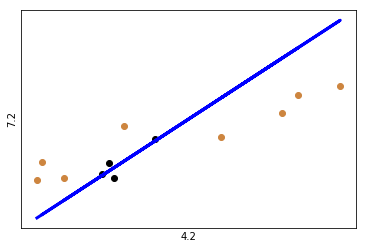

4.2 7.2
MAE: 0.68566
RMSE: 0.71375
R2: 0.000
--------------------------




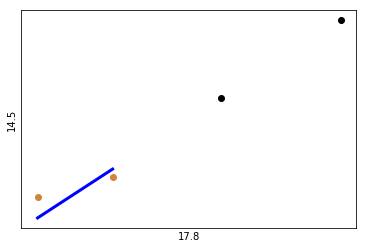

17.8 14.5
MAE: 0.82265
RMSE: 0.89713
R2: 0.000
--------------------------




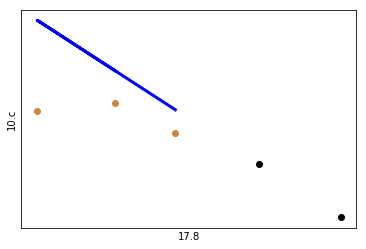

17.8 10.c
MAE: 0.64070
RMSE: 0.75045
R2: 0.000
--------------------------




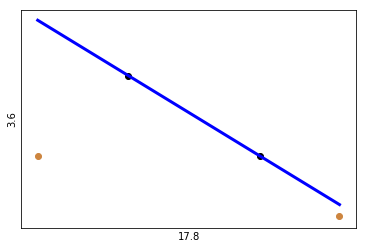

17.8 3.6
MAE: 0.07339
RMSE: 0.09591
R2: 0.000
--------------------------




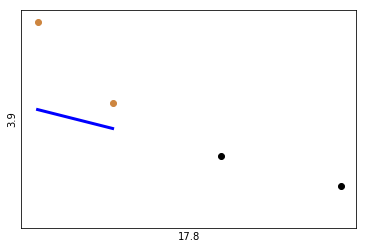

17.8 3.9
MAE: 0.02456
RMSE: 0.02799
R2: 0.000
--------------------------


17.8 7.1
MAE: 1.10039
RMSE: 1.14654
R2: 0.392
--------------------------


17.8 3.1
MAE: 3.17172
RMSE: 3.60208
R2: 0.000
--------------------------




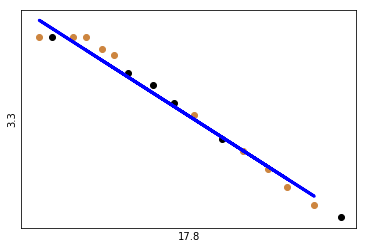

17.8 3.3
MAE: 0.13790
RMSE: 0.16136
R2: 0.978
--------------------------




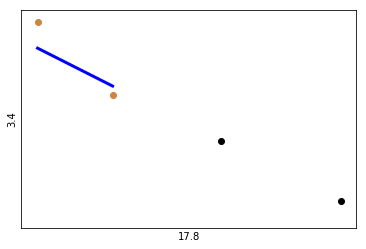

17.8 3.4
MAE: 0.01479
RMSE: 0.01645
R2: 0.709
--------------------------




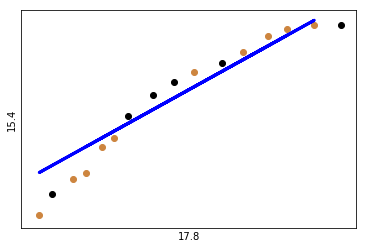

17.8 15.4
MAE: 0.83089
RMSE: 1.03991
R2: 0.918
--------------------------


17.8 8.1
MAE: 1.17027
RMSE: 1.77796
R2: 0.000
--------------------------




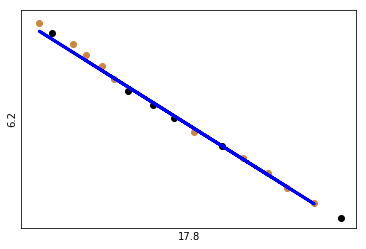

17.8 6.2
MAE: 0.17868
RMSE: 0.22908
R2: 0.995
--------------------------


17.8 9.c
MAE: 6.95154
RMSE: 8.45694
R2: 0.712
--------------------------




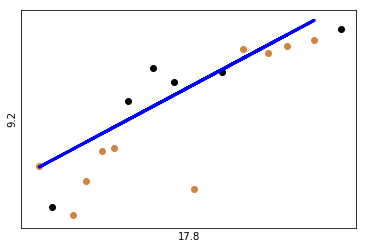

17.8 9.2
MAE: 0.20774
RMSE: 0.29872
R2: 0.570
--------------------------


17.8 14.4
MAE: 5.74640
RMSE: 5.94922
R2: 0.000
--------------------------


17.8 16.a
MAE: 7.66216
RMSE: 9.16735
R2: 0.000
--------------------------


17.8 15.1
MAE: 1.18916
RMSE: 1.65005
R2: 0.827
--------------------------




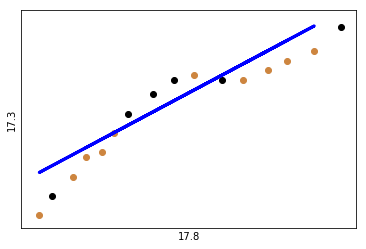

17.8 17.3
MAE: 0.03817
RMSE: 0.04391
R2: 0.846
--------------------------




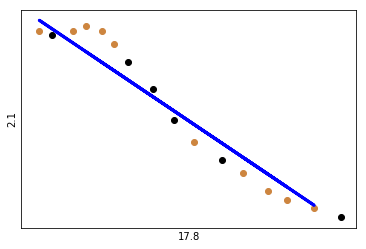

17.8 2.1
MAE: 0.38410
RMSE: 0.42504
R2: 0.940
--------------------------


17.8 6.1
MAE: 1.90819
RMSE: 2.20357
R2: 0.851
--------------------------


17.8 9.5
MAE: 1.65770
RMSE: 1.95830
R2: 0.967
--------------------------




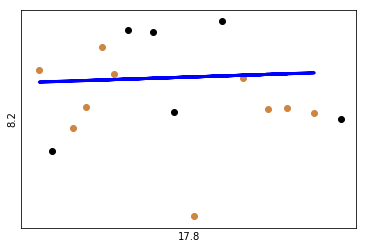

17.8 8.2
MAE: 0.91939
RMSE: 1.28500
R2: 0.000
--------------------------




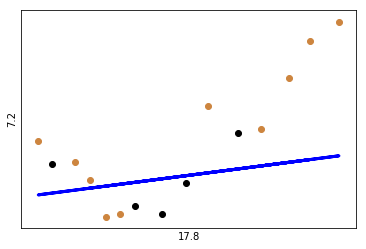

17.8 7.2
MAE: 0.43714
RMSE: 0.52595
R2: 0.000
--------------------------


17.3 14.5
MAE: 2.87682
RMSE: 4.01924
R2: 0.000
--------------------------




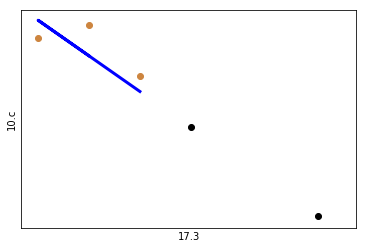

17.3 10.c
MAE: 0.16667
RMSE: 0.17474
R2: 0.000
--------------------------




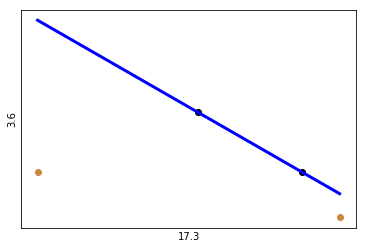

17.3 3.6
MAE: 0.11727
RMSE: 0.14564
R2: 0.000
--------------------------




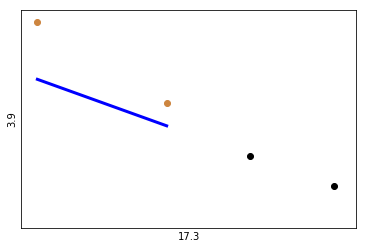

17.3 3.9
MAE: 0.01745
RMSE: 0.01898
R2: 0.000
--------------------------


17.3 7.1
MAE: 3.65000
RMSE: 4.45444
R2: 0.000
--------------------------


17.3 3.1
MAE: 1.53182
RMSE: 1.56734
R2: 0.650
--------------------------




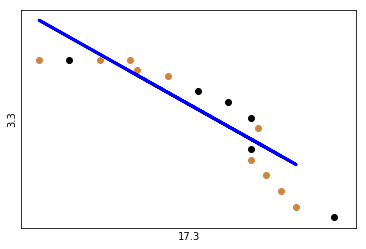

17.3 3.3
MAE: 0.41743
RMSE: 0.48441
R2: 0.801
--------------------------




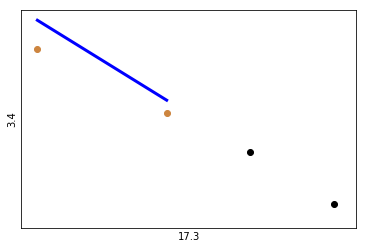

17.3 3.4
MAE: 0.02014
RMSE: 0.02172
R2: 0.493
--------------------------




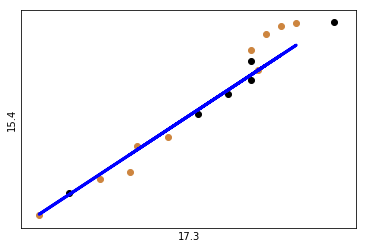

17.3 15.4
MAE: 0.75286
RMSE: 0.96806
R2: 0.929
--------------------------


17.3 8.1
MAE: 1.20301
RMSE: 1.82871
R2: 0.000
--------------------------




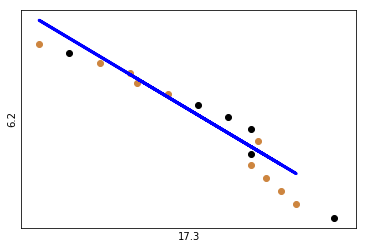

17.3 6.2
MAE: 0.82559
RMSE: 1.00865
R2: 0.897
--------------------------


17.3 9.c
MAE: 7.87280
RMSE: 10.04653
R2: 0.594
--------------------------




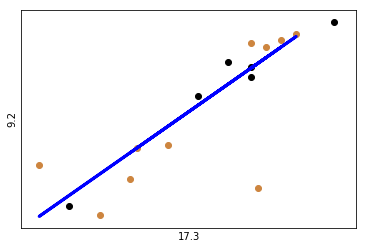

17.3 9.2
MAE: 0.20841
RMSE: 0.31592
R2: 0.519
--------------------------


17.3 14.4
MAE: 6.19673
RMSE: 6.39515
R2: 0.000
--------------------------


17.3 16.a
MAE: 6.24091
RMSE: 7.32813
R2: 0.000
--------------------------




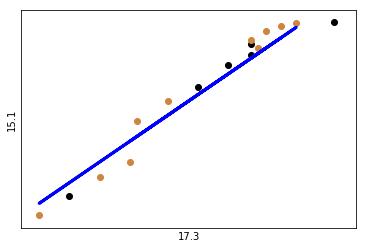

17.3 15.1
MAE: 0.78278
RMSE: 0.83794
R2: 0.955
--------------------------




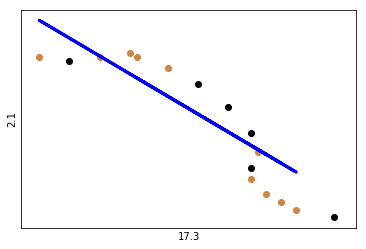

17.3 2.1
MAE: 0.68232
RMSE: 0.77203
R2: 0.802
--------------------------


17.3 6.1
MAE: 1.21110
RMSE: 1.59793
R2: 0.922
--------------------------


17.3 9.5
MAE: 3.12743
RMSE: 3.99630
R2: 0.862
--------------------------


17.3 8.2
MAE: 1.02012
RMSE: 1.36498
R2: 0.000
--------------------------




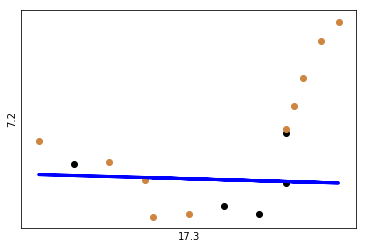

17.3 7.2
MAE: 0.48742
RMSE: 0.61578
R2: 0.000
--------------------------


2.1 14.5
MAE: 4.34192
RMSE: 4.34246
R2: 0.000
--------------------------


2.1 10.c
MAE: 1.00000
RMSE: 1.27279
R2: 0.000
--------------------------




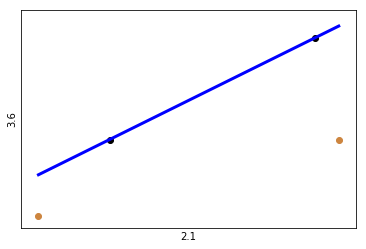

2.1 3.6
MAE: 0.06077
RMSE: 0.06710
R2: 0.000
--------------------------




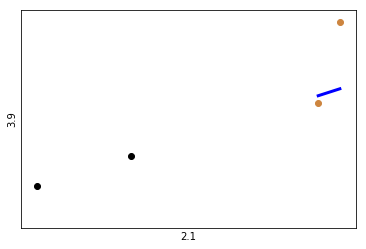

2.1 3.9
MAE: 0.01600
RMSE: 0.02062
R2: 0.000
--------------------------


2.1 7.1
MAE: 1.52000
RMSE: 1.86620
R2: 0.000
--------------------------


2.1 3.1
MAE: 2.30385
RMSE: 2.35830
R2: 0.208
--------------------------




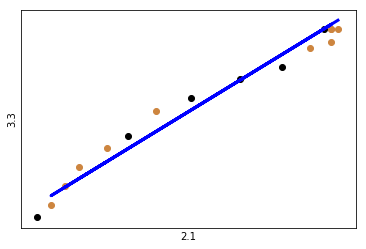

2.1 3.3
MAE: 0.16390
RMSE: 0.18682
R2: 0.970
--------------------------




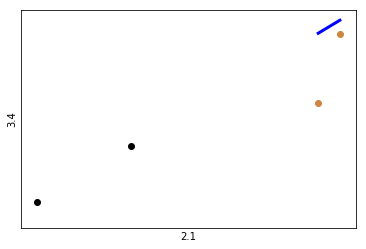

2.1 3.4
MAE: 0.03727
RMSE: 0.04473
R2: 0.000
--------------------------




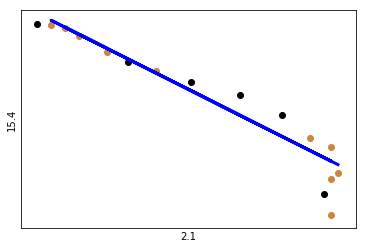

2.1 15.4
MAE: 0.63810
RMSE: 1.03489
R2: 0.919
--------------------------


2.1 8.1
MAE: 1.13497
RMSE: 1.75844
R2: 0.000
--------------------------




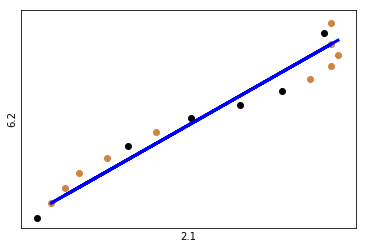

2.1 6.2
MAE: 0.64914
RMSE: 0.75456
R2: 0.943
--------------------------


2.1 9.c
MAE: 4.65208
RMSE: 6.08344
R2: 0.851
--------------------------




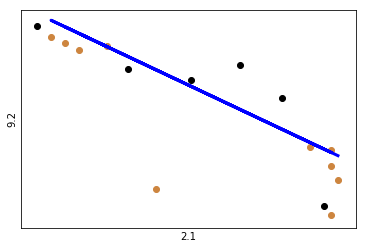

2.1 9.2
MAE: 0.19020
RMSE: 0.30487
R2: 0.552
--------------------------


2.1 14.4
MAE: 4.57783
RMSE: 4.85263
R2: 0.509
--------------------------


2.1 16.a
MAE: 5.55000
RMSE: 7.70876
R2: 0.000
--------------------------


2.1 15.1
MAE: 1.36585
RMSE: 1.77140
R2: 0.800
--------------------------


2.1 6.1
MAE: 1.56060
RMSE: 1.96041
R2: 0.882
--------------------------


2.1 9.5
MAE: 1.75977
RMSE: 2.20247
R2: 0.958
--------------------------




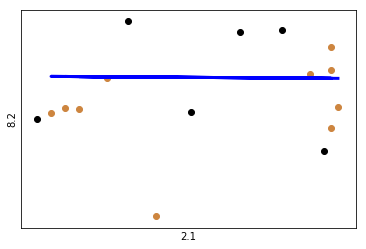

2.1 8.2
MAE: 0.88930
RMSE: 1.27324
R2: 0.000
--------------------------




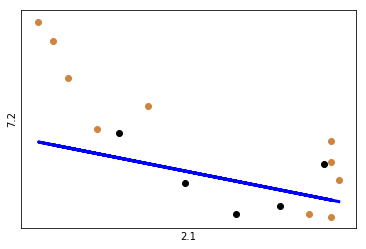

2.1 7.2
MAE: 0.39175
RMSE: 0.46826
R2: 0.024
--------------------------


6.1 14.5
MAE: 72.27446
RMSE: 75.50068
R2: 0.000
--------------------------


6.1 10.c
MAE: 1.28636
RMSE: 1.51310
R2: 0.000
--------------------------




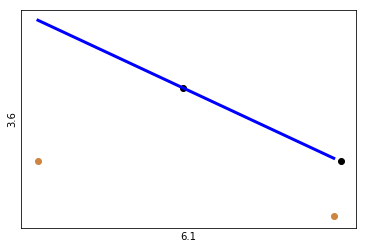

6.1 3.6
MAE: 0.10879
RMSE: 0.11784
R2: 0.000
--------------------------




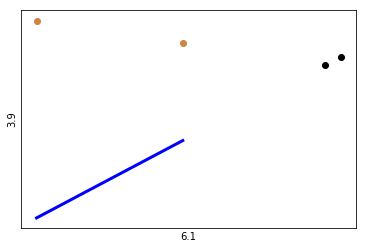

6.1 3.9
MAE: 0.23532
RMSE: 0.24828
R2: 0.000
--------------------------


6.1 7.1
MAE: 66.14846
RMSE: 69.29378
R2: 0.000
--------------------------


6.1 3.1
MAE: 51.80946
RMSE: 54.48986
R2: 0.000
--------------------------




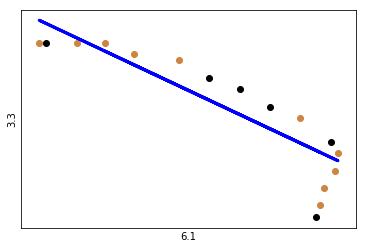

6.1 3.3
MAE: 0.34786
RMSE: 0.42568
R2: 0.847
--------------------------




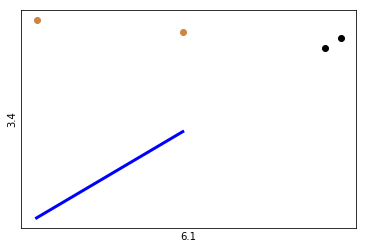

6.1 3.4
MAE: 0.81782
RMSE: 0.86051
R2: 0.000
--------------------------




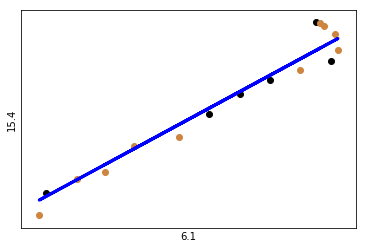

6.1 15.4
MAE: 0.59816
RMSE: 0.70712
R2: 0.962
--------------------------


6.1 8.1
MAE: 1.36561
RMSE: 1.95118
R2: 0.000
--------------------------




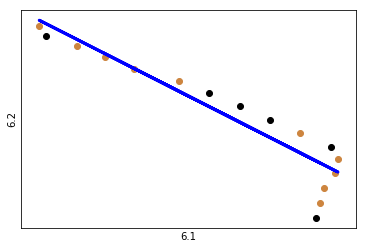

6.1 6.2
MAE: 0.64399
RMSE: 0.86797
R2: 0.924
--------------------------


6.1 9.c
MAE: 6.17656
RMSE: 8.64750
R2: 0.699
--------------------------




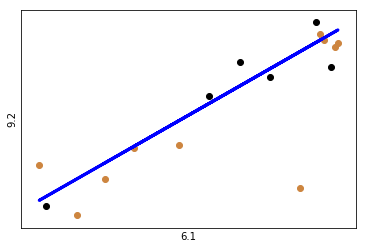

6.1 9.2
MAE: 0.19522
RMSE: 0.32131
R2: 0.502
--------------------------


6.1 14.4
MAE: 6.22052
RMSE: 6.41516
R2: 0.000
--------------------------


6.1 16.a
MAE: 49.81486
RMSE: 53.02944
R2: 0.000
--------------------------




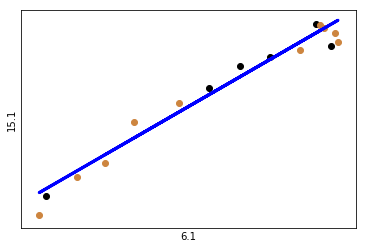

6.1 15.1
MAE: 0.64714
RMSE: 0.76113
R2: 0.963
--------------------------


6.1 9.5
MAE: 2.69490
RMSE: 3.89409
R2: 0.869
--------------------------


6.1 8.2
MAE: 1.21769
RMSE: 1.57333
R2: 0.000
--------------------------




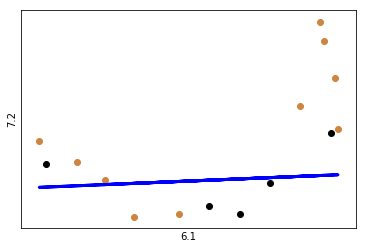

6.1 7.2
MAE: 0.47423
RMSE: 0.58695
R2: 0.000
--------------------------




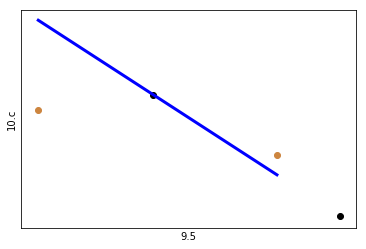

9.5 10.c
MAE: 0.36043
RMSE: 0.42824
R2: 0.000
--------------------------




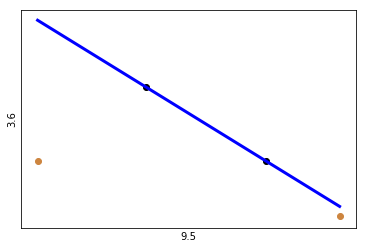

9.5 3.6
MAE: 0.08162
RMSE: 0.10804
R2: 0.000
--------------------------




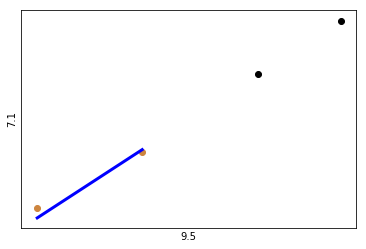

9.5 7.1
MAE: 0.33562
RMSE: 0.39865
R2: 0.926
--------------------------




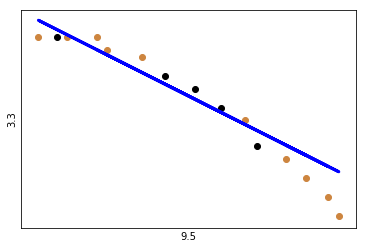

9.5 3.3
MAE: 0.26489
RMSE: 0.32852
R2: 0.909
--------------------------




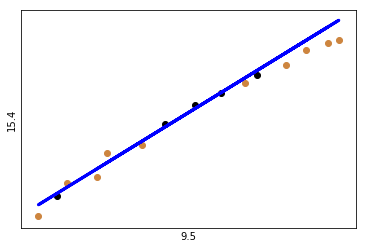

9.5 15.4
MAE: 0.58555
RMSE: 0.65160
R2: 0.968
--------------------------


9.5 8.1
MAE: 1.62613
RMSE: 2.16226
R2: 0.000
--------------------------




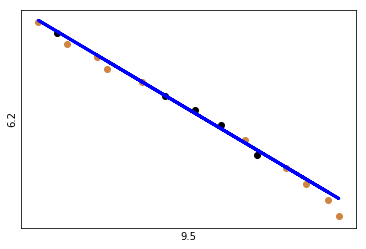

9.5 6.2
MAE: 0.24572
RMSE: 0.33636
R2: 0.989
--------------------------


9.5 9.c
MAE: 7.15715
RMSE: 9.19242
R2: 0.660
--------------------------




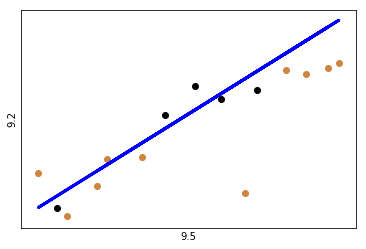

9.5 9.2
MAE: 0.27266
RMSE: 0.35862
R2: 0.380
--------------------------


9.5 14.4
MAE: 6.13423
RMSE: 6.33098
R2: 0.000
--------------------------


9.5 15.1
MAE: 1.56454
RMSE: 1.91585
R2: 0.766
--------------------------


9.5 8.2
MAE: 1.82139
RMSE: 2.27561
R2: 0.000
--------------------------




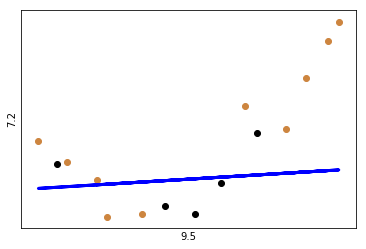

9.5 7.2
MAE: 0.46335
RMSE: 0.56961
R2: 0.000
--------------------------


8.2 14.5
MAE: 5.33933
RMSE: 6.14986
R2: 0.000
--------------------------


8.2 10.c
MAE: 1.49744
RMSE: 2.28103
R2: 0.000
--------------------------




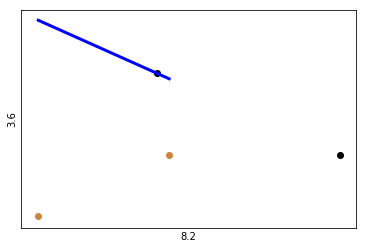

8.2 3.6
MAE: 0.13308
RMSE: 0.14541
R2: 0.000
--------------------------




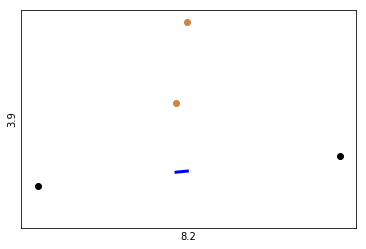

8.2 3.9
MAE: 0.04730
RMSE: 0.05035
R2: 0.000
--------------------------


8.2 7.1
MAE: 7.15013
RMSE: 7.28855
R2: 0.000
--------------------------


8.2 3.1
MAE: 8.41875
RMSE: 8.80925
R2: 0.000
--------------------------


8.2 3.3
MAE: 1.01814
RMSE: 1.08919
R2: 0.000
--------------------------




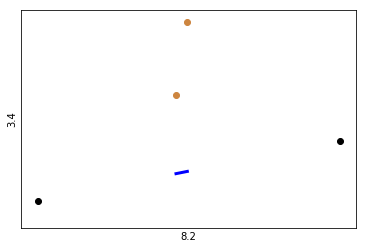

8.2 3.4
MAE: 0.09465
RMSE: 0.09916
R2: 0.000
--------------------------


8.2 15.4
MAE: 4.21540
RMSE: 5.19584
R2: 0.000
--------------------------




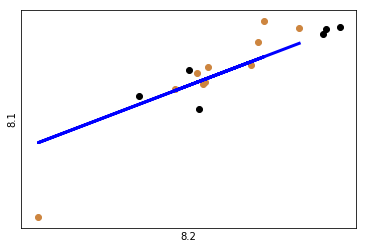

8.2 8.1
MAE: 0.55693
RMSE: 0.87702
R2: 0.719
--------------------------


8.2 6.2
MAE: 3.06365
RMSE: 3.22886
R2: 0.000
--------------------------


8.2 9.c
MAE: 16.48011
RMSE: 17.31720
R2: 0.000
--------------------------




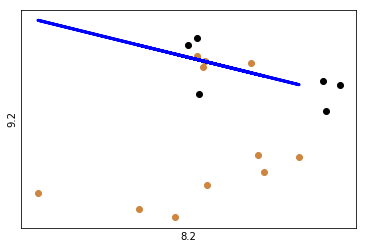

8.2 9.2
MAE: 0.61293
RMSE: 0.78787
R2: 0.000
--------------------------


8.2 14.4
MAE: 5.62103
RMSE: 5.95824
R2: 0.000
--------------------------


8.2 16.a
MAE: 8.52000
RMSE: 11.05680
R2: 0.000
--------------------------


8.2 15.1
MAE: 4.33468
RMSE: 5.73439
R2: 0.000
--------------------------




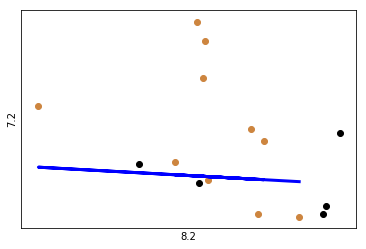

8.2 7.2
MAE: 0.46100
RMSE: 0.58282
R2: 0.000
--------------------------




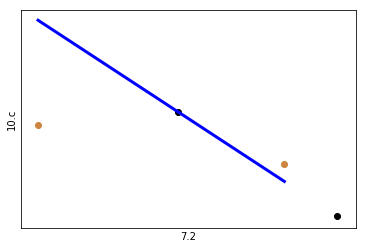

7.2 10.c
MAE: 0.46905
RMSE: 0.57681
R2: 0.000
--------------------------




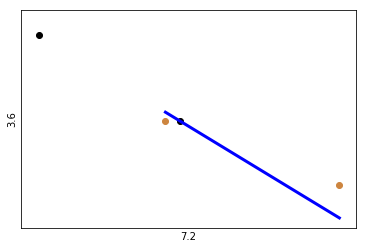

7.2 3.6
MAE: 0.01933
RMSE: 0.02241
R2: 0.442
--------------------------


7.2 7.1
MAE: 4.43707
RMSE: 5.04700
R2: 0.000
--------------------------




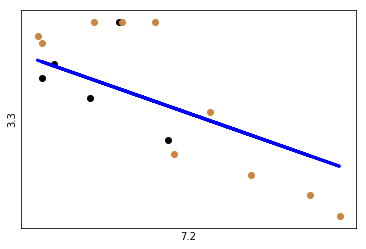

7.2 3.3
MAE: 0.62160
RMSE: 0.69085
R2: 0.596
--------------------------


7.2 15.4
MAE: 3.12668
RMSE: 3.37294
R2: 0.142
--------------------------




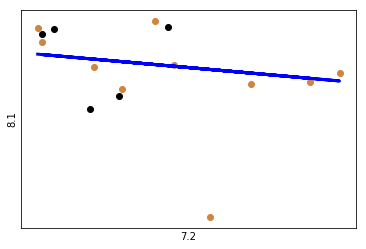

7.2 8.1
MAE: 0.92004
RMSE: 1.61301
R2: 0.050
--------------------------


7.2 6.2
MAE: 2.25685
RMSE: 2.51388
R2: 0.362
--------------------------


7.2 9.c
MAE: 16.13892
RMSE: 17.13892
R2: 0.000
--------------------------




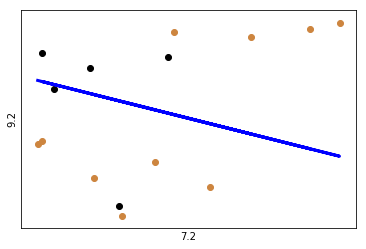

7.2 9.2
MAE: 0.54983
RMSE: 0.57537
R2: 0.000
--------------------------


7.2 14.4
MAE: 5.44173
RMSE: 5.70645
R2: 0.000
--------------------------


7.2 15.1
MAE: 3.98752
RMSE: 4.31011
R2: 0.000
--------------------------




In [45]:
keep =[]
processedPairs = list()
notPercentTargets = ['12.2', '9.4', '8.4', '17.2', '17.19']   # work on this
highValueTargets = ['9.4', '17.19']
discardedPairs = list()

n_connections = 0

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    if ((targety in notPercentTargets and not targetx in notPercentTargets) or targety in highValueTargets):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        if targety in notPercentTargets:
                            if 0<=mae<0.5: # 5 percent tolerance (converted to tonnes)
                                #print('MAE', targetx, targety, mae)
                                keep.append((final_t[targetx], final_t[targety]))

                                plt.scatter(X_train, Y_train,  color='black')
                                plt.scatter(X_valid, Y_valid, color='peru')
                                plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                plt.xticks(())
                                plt.yticks(())
                                plt.xlabel(targetx)
                                plt.ylabel(targety)
                                plt.show()
                                
                                n_connections = n_connections + 1
                            
                            else: discardedPairs.extend([set([targetx, targety])])


                        else:
                            if 1 > mae > 0: # tolerate 1 percent error
                                keep.append((final_t[targetx], final_t[targety]))

                                plt.scatter(X_train, Y_train,  color='black')
                                plt.scatter(X_valid, Y_valid, color='peru')
                                plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                plt.xticks(())
                                plt.yticks(())
                                plt.xlabel(targetx)
                                plt.ylabel(targety)
                                plt.show()
                                
                                n_connections = n_connections + 1
                                
                            else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('--------------------------')
                        print('\n')

#print(keep)

In [46]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  141


In [47]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
print(discardedPairs)

[['8.4', '3.3'], ['9.4', '8.1'], ['9.4', '9.c'], ['9.4', '14.4'], {'17.19', '9.4'}, ['17.19', '15.1'], ['17.19', '4.2'], ['17.19', '17.8'], ['17.19', '2.1'], ['17.19', '6.1'], ['17.19', '9.5'], ['17.19', '8.2'], ['8.4', '15.4'], ['8.4', '8.1'], ['8.4', '6.2'], ['8.4', '9.c'], ['8.4', '14.4'], ['8.4', '17.8'], ['8.4', '2.1'], ['8.4', '6.1'], ['8.4', '9.5'], ['8.4', '8.2'], ['8.4', '7.2'], ['17.2', '14.5'], ['17.2', '7.1'], ['17.2', '3.1'], ['9.4', '15.1'], ['9.4', '4.2'], ['9.4', '17.8'], ['9.4', '6.1'], ['9.4', '9.5'], ['9.4', '8.2'], ['3.1', '14.5'], ['3.1', '3.3'], ['3.3', '10.c'], ['3.3', '7.1'], ['3.4', '14.5'], ['9.4', '7.1'], ['15.4', '14.5'], ['15.4', '10.c'], ['15.4', '7.1'], ['17.2', '15.4'], {'12.2', '17.2'}, ['17.2', '8.1'], ['17.2', '6.2'], ['17.2', '9.c'], ['17.2', '14.4'], ['12.2', '3.3'], ['12.2', '15.4'], ['12.2', '8.1'], ['12.2', '6.2'], ['12.2', '9.c'], ['12.2', '14.4'], ['8.1', '14.5'], ['8.1', '10.c'], ['8.1', '7.1'], ['8.1', '3.1'], ['8.1', '3.3'], ['8.1', '15.4'],

### perhaps needed
what needs to be done before

#### what will happen next:

we have a temporal model with missing observations as NaNs, and want to infer them

In [ ]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

In [ ]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

## Define STAN model

In [ ]:
SDG_STAN="""
data {
    int<lower = 0> N_obs;    // we might need such a variable for each observed variable because they could be different
    int<lower = 0> N_mis;    // how many do we want to infer
    int<lower = 1, upper = N_obs + N_mis> ix_obs1[N_obs];    // index for observed variable 1
    int<lower = 1, upper = N_obs + N_mis> ix_mis1[N_mis];
    int<lower = 1, upper = N_obs + N_mis> ix_obs2[N_obs];    // index for observed variable 2 -> more?
    int<lower = 1, upper = N_obs + N_mis> ix_mis2[N_mis];
    real y_obs1[N_obs];         // observed time-series data for variable 1
    real y_obs2[N_obs];         // observed time-series data for variable 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients
    corr_matrix[2] Omega;    // 2 because of two observed variables -> in our case 
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis];        // missing time-series data (to infer)
    real y_mis2[N_mis];        // missing time-series data (to infer)
}
model {
    for(i in 1:2)                   // 2 again because of two observed variables
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1  
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    for(t in 2:T) {
        vector[2] mu;
        mu[1] = beta[1]' * z[(t-1):(t-1),1];
        mu[2] = beta[2]' * z[(t-1):(t-1),2];
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood
    y2 ~ normal(z[:,2], sigma);    // likelihood
}
"""

In [ ]:
# prepare data for STAN model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

In [ ]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

In [ ]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
fit.plot(["tau","sigma","lp__"])
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
# insert def compute_error if deleted above
mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))